# Анализ маркетинговых данных

В соответствии с заданием должен быть проведен анализ макркетинговых данных по приложению.
В качестве проблемы обозначена низкая эффективность рекламы при значительных вложениях. Для анализа предоставлена следующая информация:
1. Таблица visits_log_short (лог сервера с информацией о посещениях сайта):

 * User Id — уникальный идентификатор пользователя
 * Device — категория устройства пользователя
 * Session start — дата и время начала сессии
 * Session End — дата и время окончания сессии
 * Channel — идентификатор рекламного источника, из которого пришел пользователь
 * Region - страна пользователя

2. Таблица orders_log_short (информация о заказах):

 * User Id — уникальный id пользователя, который сделал заказ
 * Event Dt — дата и время покупки
 * Revenue — выручка

3. Таблица costs_short (информация о затратах на маркетинг):

 * Channel — идентификатор рекламного источника
 * Dt — дата
 * Costs — затраты на этот рекламный источник в этот день

# Шаг 1. Загрузка и предобработка данных

In [1]:
import pandas as pd
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
import numpy as np
pd.set_option('display.float_format', '{:.2f}'.format)

visits = pd.read_csv('/datasets/visits_info_short.csv')
orders = pd.read_csv('/datasets/orders_info_short.csv')
costs = pd.read_csv('/datasets/costs_info_short.csv')

def df_scope(*dfs, dupl_check=False):  # функция выводит информацию по датафреймам для общего обзора
    for df in dfs:
        df.info()
        display(df.head(10))
        if dupl_check:  # также опционально проверяется наличие дубликатов
            print('Дубликаты:', df.duplicated().sum())
            print()

# ознакомимся с загруженной информацией
df_scope(visits, orders, costs, dupl_check=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
User Id          309901 non-null int64
Region           309901 non-null object
Device           309901 non-null object
Channel          309901 non-null object
Session Start    309901 non-null object
Session End      309901 non-null object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB


,User Id,Region,Device,Channel,Session Start,Session End
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01
1,278965908054,United States,iPhone,organic,2019-05-01 04:46:31,2019-05-01 04:47:35
2,590706206550,United States,Mac,organic,2019-05-01 14:09:25,2019-05-01 15:32:08
3,326433527971,United States,Android,TipTop,2019-05-01 00:29:59,2019-05-01 00:54:25
4,349773784594,United States,Mac,organic,2019-05-01 03:33:35,2019-05-01 03:57:40
5,90242400005,United States,iPhone,RocketSuperAds,2019-05-01 07:14:52,2019-05-01 08:19:56
6,43958116050,United States,Android,organic,2019-05-01 09:03:21,2019-05-01 10:08:39
7,185365244969,United States,iPhone,organic,2019-05-01 09:37:03,2019-05-01 10:00:43
8,446013509831,United States,iPhone,RocketSuperAds,2019-05-01 10:26:00,2019-05-01 10:59:17
9,100970711362,United States,Mac,TipTop,2019-05-01 04:39:53,2019-05-01 04:57:05


Дубликаты: 0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
User Id     40212 non-null int64
Event Dt    40212 non-null object
Revenue     40212 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB


,User Id,Event Dt,Revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99
2,529610067795,2019-05-01 11:34:04,4.99
3,319939546352,2019-05-01 15:34:40,4.99
4,366000285810,2019-05-01 13:59:51,4.99
5,129100331057,2019-05-01 01:56:28,4.99
6,626807144131,2019-05-01 02:39:21,4.99
7,914062168985,2019-05-01 02:02:18,4.99
8,769669137453,2019-05-01 03:39:47,4.99
9,434198630691,2019-05-01 18:16:50,5.99


Дубликаты: 0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
dt         1800 non-null object
Channel    1800 non-null object
costs      1800 non-null float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


,dt,Channel,costs
0,2019-05-01,FaceBoom,113.30
1,2019-05-02,FaceBoom,78.10
2,2019-05-03,FaceBoom,85.80
3,2019-05-04,FaceBoom,136.40
4,2019-05-05,FaceBoom,122.10
5,2019-05-06,FaceBoom,118.80
6,2019-05-07,FaceBoom,101.20
7,2019-05-08,FaceBoom,100.10
8,2019-05-09,FaceBoom,93.50
9,2019-05-10,FaceBoom,104.50


Дубликаты: 0



In [2]:
def df_corrector(*dfs):  # функция приводит названия столбцов к виду snake-case
    for df in dfs:
        df.columns=df.columns.str.lower()
        df.columns=df.columns.str.replace(' ','_')
df_corrector(visits, orders, costs)

visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])
orders['event_dt'] = pd.to_datetime(orders['event_dt'])
costs['dt'] = pd.to_datetime(costs['dt']).dt.date

df_scope(visits, orders, costs)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
user_id          309901 non-null int64
region           309901 non-null object
device           309901 non-null object
channel          309901 non-null object
session_start    309901 non-null datetime64[ns]
session_end      309901 non-null datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(3)
memory usage: 14.2+ MB


,user_id,region,device,channel,session_start,session_end
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01
1,278965908054,United States,iPhone,organic,2019-05-01 04:46:31,2019-05-01 04:47:35
2,590706206550,United States,Mac,organic,2019-05-01 14:09:25,2019-05-01 15:32:08
3,326433527971,United States,Android,TipTop,2019-05-01 00:29:59,2019-05-01 00:54:25
4,349773784594,United States,Mac,organic,2019-05-01 03:33:35,2019-05-01 03:57:40
5,90242400005,United States,iPhone,RocketSuperAds,2019-05-01 07:14:52,2019-05-01 08:19:56
6,43958116050,United States,Android,organic,2019-05-01 09:03:21,2019-05-01 10:08:39
7,185365244969,United States,iPhone,organic,2019-05-01 09:37:03,2019-05-01 10:00:43
8,446013509831,United States,iPhone,RocketSuperAds,2019-05-01 10:26:00,2019-05-01 10:59:17
9,100970711362,United States,Mac,TipTop,2019-05-01 04:39:53,2019-05-01 04:57:05


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
user_id     40212 non-null int64
event_dt    40212 non-null datetime64[ns]
revenue     40212 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 942.6 KB


,user_id,event_dt,revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99
2,529610067795,2019-05-01 11:34:04,4.99
3,319939546352,2019-05-01 15:34:40,4.99
4,366000285810,2019-05-01 13:59:51,4.99
5,129100331057,2019-05-01 01:56:28,4.99
6,626807144131,2019-05-01 02:39:21,4.99
7,914062168985,2019-05-01 02:02:18,4.99
8,769669137453,2019-05-01 03:39:47,4.99
9,434198630691,2019-05-01 18:16:50,5.99


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
dt         1800 non-null object
channel    1800 non-null object
costs      1800 non-null float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


,dt,channel,costs
0,2019-05-01,FaceBoom,113.30
1,2019-05-02,FaceBoom,78.10
2,2019-05-03,FaceBoom,85.80
3,2019-05-04,FaceBoom,136.40
4,2019-05-05,FaceBoom,122.10
5,2019-05-06,FaceBoom,118.80
6,2019-05-07,FaceBoom,101.20
7,2019-05-08,FaceBoom,100.10
8,2019-05-09,FaceBoom,93.50
9,2019-05-10,FaceBoom,104.50


# Шаг 2. Функции для расчета и анализа LTV, ROI, удержания и конверсии

Разрешается использовать функции, с которыми вы познакомились в теоретических уроках.

**Функция для создания пользовательских профилей**

In [3]:


def get_profiles(sessions, orders, ad_costs):

    # находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles

**Функция для расчёта удержания**

In [4]:
def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

**Функция для расчёта конверсии**

In [5]:
def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

**Функция для расчёта LTV и ROI**

In [6]:
def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    )

**Функция для сглаживания фрейма**

In [7]:
def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df

**Функция для визуализации удержания**

In [8]:
def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show()

**Функция для визуализации конверсии**

In [9]:


def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

**Функция для визуализации LTV и ROI**

In [10]:


def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

# Шаг 3. Исследовательский анализ данных

In [11]:
profiles = get_profiles(sessions=visits, orders=orders, ad_costs=costs)
profiles

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.09
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.11
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,False,0.00
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.99
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.23
...,...,...,...,...,...,...,...,...,...
150003,999956196527,2019-09-28 08:33:02,TipTop,iPhone,United States,2019-09-28,2019-09-01,False,3.50
150004,999975439887,2019-10-21 00:35:17,organic,PC,UK,2019-10-21,2019-10-01,False,0.00
150005,999976332130,2019-07-23 02:57:06,TipTop,iPhone,United States,2019-07-23,2019-07-01,False,2.60
150006,999979924135,2019-09-28 21:28:09,MediaTornado,PC,United States,2019-09-28,2019-09-01,False,0.21


In [12]:
print(f'Минимальная дата привлечения пользователей: {profiles["first_ts"].dt.date.min()}')
print(f'Максимальная дата привлечения пользователей: {profiles["first_ts"].dt.date.max()}')

Минимальная дата привлечения пользователей: 2019-05-01
Максимальная дата привлечения пользователей: 2019-10-27


In [13]:
cat = {'region': 'Платящие пользователи в разбивке по странам',
       'device': 'Платящие пользователи в разбивке по устройствам',
       'channel': 'Платящие пользователи в разбивке по каналам'}

def payers_cat(cat_dict):
    for cat, cat_name in cat_dict.items():
        print(cat_name)
        display(profiles
                .pivot_table(index=cat,
                             aggfunc=('sum', 'mean'),
                             values='payer')
                .sort_values(by='mean', ascending=False)
                .rename(columns={'sum':'payers_ttl',
                                 'mean':'payers_pct'}))
payers_cat(cat)

Платящие пользователи в разбивке по странам


,payers_pct,payers_ttl
region,,
United States,0.07,6902.00
Germany,0.04,616.00
UK,0.04,700.00
France,0.04,663.00


Платящие пользователи в разбивке по устройствам


,payers_pct,payers_ttl
device,,
Mac,0.06,1912.00
iPhone,0.06,3382.00
Android,0.06,2050.00
PC,0.05,1537.00


Платящие пользователи в разбивке по каналам


,payers_pct,payers_ttl
channel,,
FaceBoom,0.12,3557.00
AdNonSense,0.11,440.00
lambdaMediaAds,0.10,225.00
TipTop,0.10,1878.00
RocketSuperAds,0.08,352.00
WahooNetBanner,0.05,453.00
YRabbit,0.04,165.00
MediaTornado,0.04,156.00
LeapBob,0.03,262.00


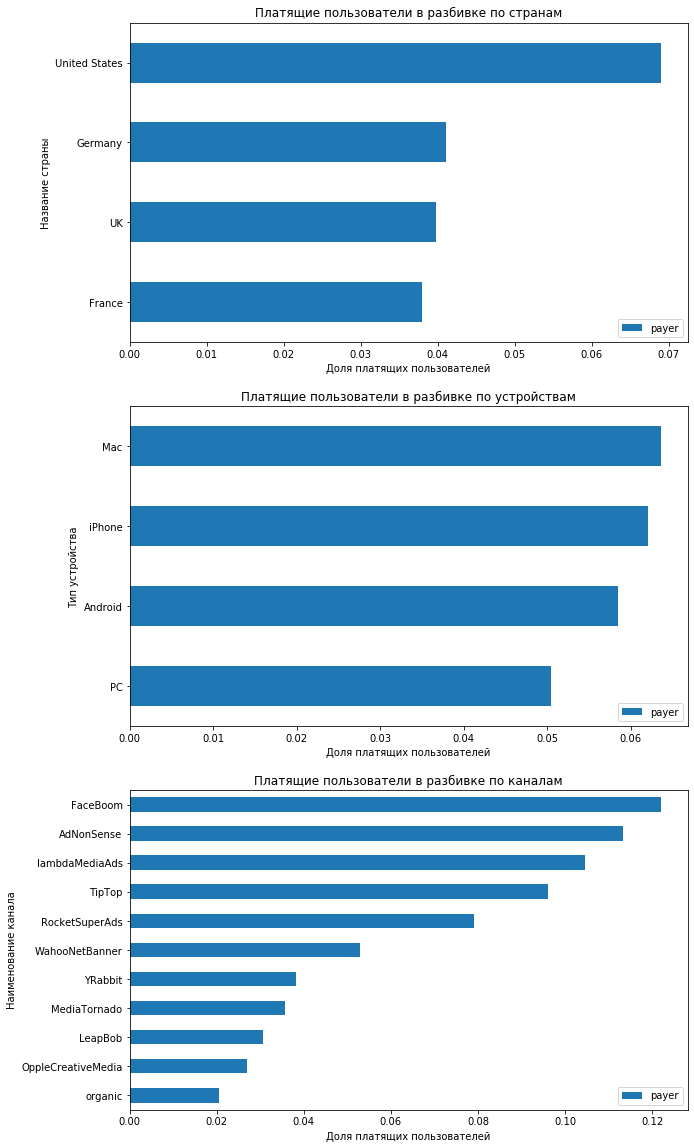

In [14]:
plt.figure(figsize=(10, 20))
profiles.groupby('region').agg({'payer':'mean'}).sort_values(by='payer').plot(kind='barh', ax=plt.subplot(3, 1, 1))
plt.ylabel('Название страны')
plt.xlabel('Доля платящих пользователей')
plt.title('Платящие пользователи в разбивке по странам')
profiles.groupby('device').agg({'payer':'mean'}).sort_values(by='payer').plot(kind='barh', ax=plt.subplot(3, 1, 2))
plt.ylabel('Тип устройства')
plt.xlabel('Доля платящих пользователей')
plt.title('Платящие пользователи в разбивке по устройствам')
profiles.groupby('channel').agg({'payer':'mean'}).sort_values(by='payer').plot(kind='barh', ax=plt.subplot(3, 1, 3))
plt.ylabel('Наименование канала')
plt.xlabel('Доля платящих пользователей')
plt.title('Платящие пользователи в разбивке по каналам')
plt.show()

**Вывод по шагу 3**
1. Впервые в выборке пользователь привлечен 1 мая 2019 года, в последний раз 27 октября 2019 года.
2. Пользователи приходят из четырёх стран: США, Германии, Великобритании и Франции. Наибольшая доля платящих пользователей со значительным отрывом от остальных стран в США (6,9%), на втором месте Германия (4,1%).
3. Пользователи заходят с четырёх устройств: Mac, iPhone, Android и PC. Наибольшая доля платящих пользователей заходит с Mac (6,4%), на втором месте iPhone (6,2%).
4. Привлечение шло по 11 каналам. По доле платящих пользователей лидируют FaceBoom (12,2%), AdNonSense (11,4%), lambdaMediaAds (10,5%).

# Шаг 4. Маркетинг

Выясните:
- Сколько денег потратили? Всего / на каждый источник / по времени
- Сколько в среднем стоило привлечение одного покупателя из каждого источника?

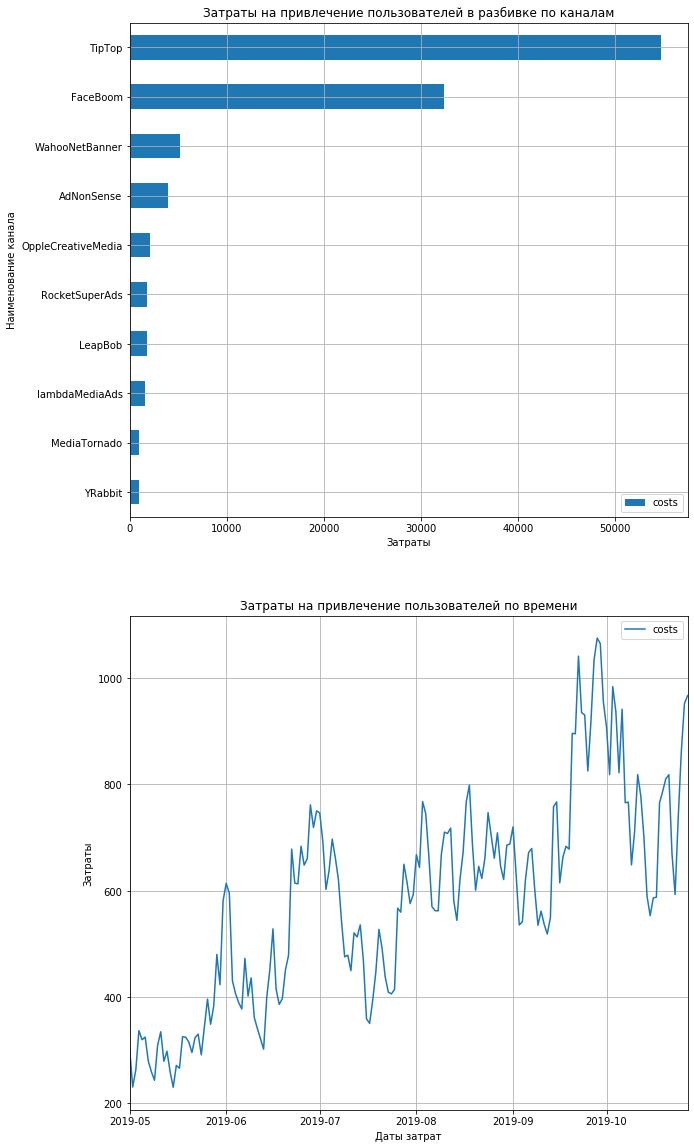

<Figure size 1440x2880 with 0 Axes>

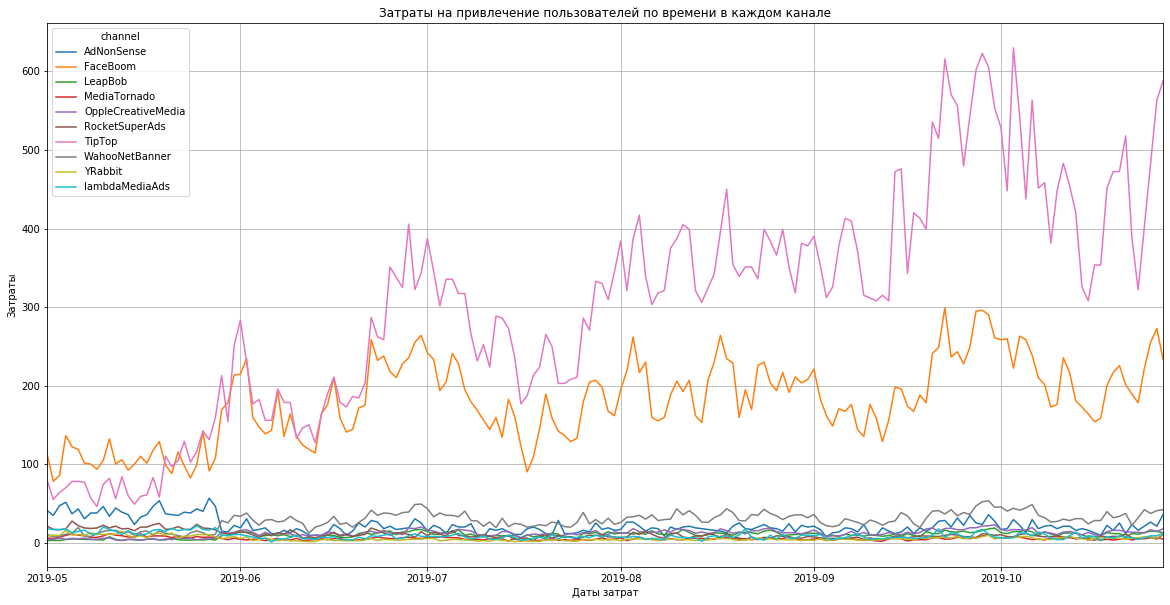

In [15]:
plt.figure(figsize=(10, 20))
costs.groupby('channel').agg({'costs':'sum'}).sort_values(by='costs').plot(kind='barh', grid=True, ax=plt.subplot(2, 1, 1))
plt.ylabel('Наименование канала')
plt.xlabel('Затраты')
plt.title('Затраты на привлечение пользователей в разбивке по каналам')
costs.groupby('dt').agg({'costs':'sum'}).sort_values(by='costs').plot(ax=plt.subplot(2, 1, 2), grid=True)
plt.ylabel('Затраты')
plt.xlabel('Даты затрат')
plt.title('Затраты на привлечение пользователей по времени')
plt.show()

plt.figure(figsize=(20, 40))
costs.pivot_table(index='channel', columns='dt', values='costs', aggfunc='sum').T.plot(grid=True, figsize=(20, 10))
plt.ylabel('Затраты')
plt.xlabel('Даты затрат')
plt.title('Затраты на привлечение пользователей по времени в каждом канале')
plt.show()

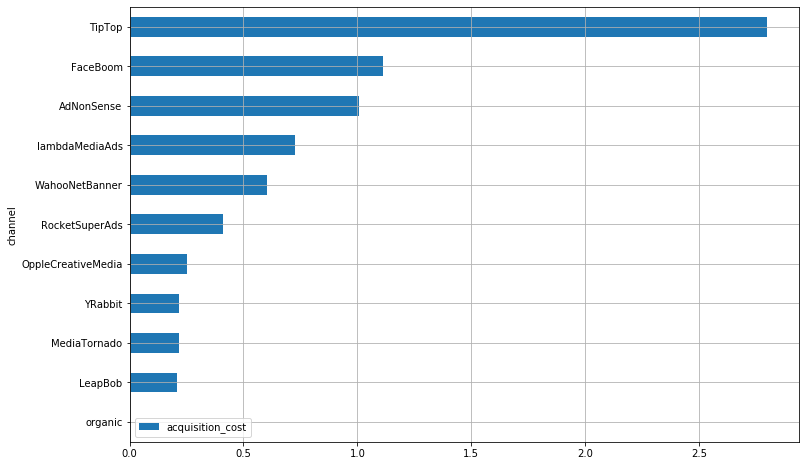

In [16]:
profiles.groupby('channel').agg({'acquisition_cost':'mean'}).sort_values(by='acquisition_cost').plot(kind='barh',
                                                                                                     grid=True,
                                                                                                     figsize=(12, 8))
plt.show()

In [17]:
print(f'Общие затраты на привлечение пользователей: {costs["costs"].sum():.2f} у.е.')

Общие затраты на привлечение пользователей: 105497.30 у.е.


In [18]:
cac_ttl = costs["costs"].sum() / profiles.query('channel != "organic"').shape[0]
print(f'Общие затраты по проекту: {costs["costs"].sum():.2f} у.е.')
print(f'CAC по проекту: {cac_ttl:.2f} у.е.')

Общие затраты по проекту: 105497.30 у.е.
CAC по проекту: 1.13 у.е.


**Вывод по шагу 4**

1. В соответствии с полученными данными общие затраты на привлечение пользователей растут.
2. Рост затрат наблюдается в каналах TipTop и FaceBoom.
3. По величине CAC с большим отрывом лидирует TipTop.

# Шаг 5. Оценка окупаемости рекламы для привлечения пользователей

### Общая окупаемость рекламы

In [19]:
observation_date = datetime(2019, 11, 1).date()  # момент анализа
horizon_days = 14  # горизонт анализа

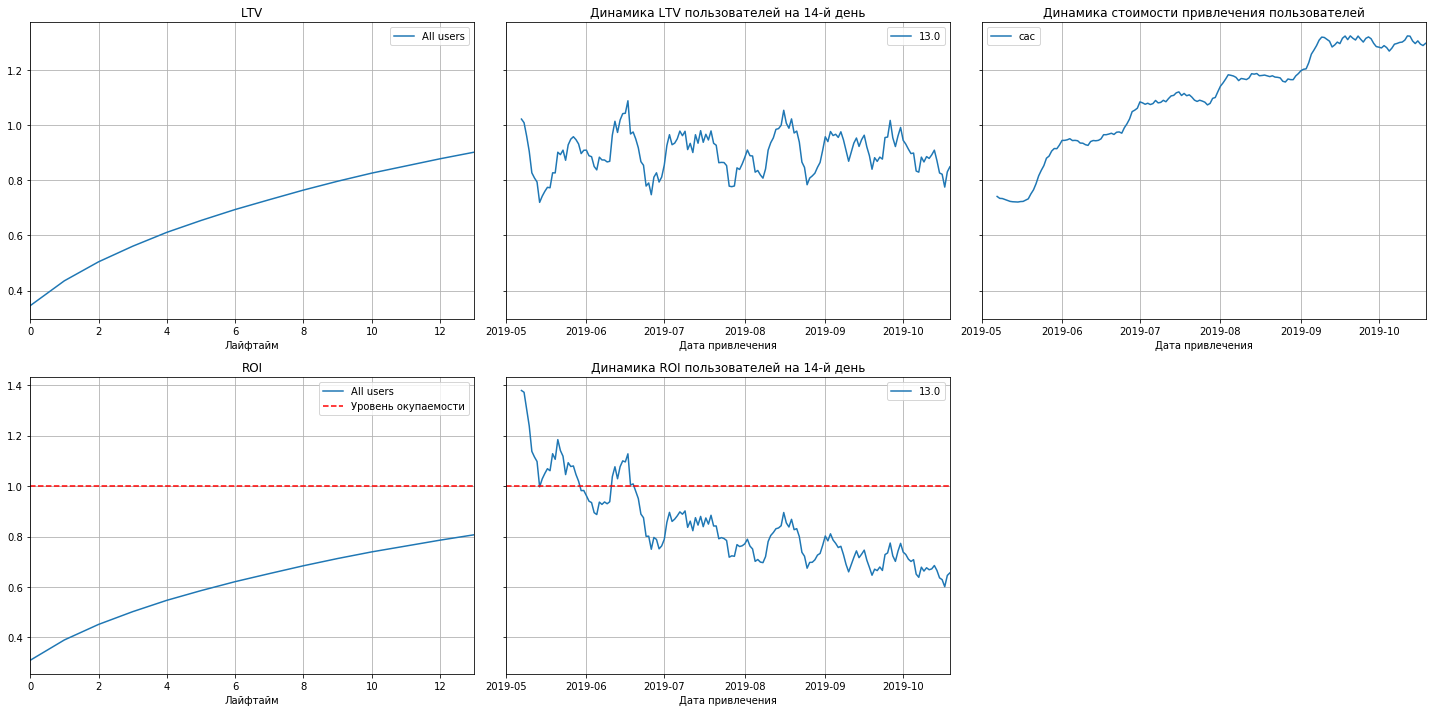

In [20]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
   profiles.query('channel != "organic"'), orders, observation_date, horizon_days
)

# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days)

Не смотря на то, что LTV растёт, ROI не пересекает уровень окупаемости за первые две недели. При этом заметен рост затрат на привлечение пользователей, что приводит к падению динамики возврата инвестиций.

### Окупаемость рекламы с разбивкой по устройствам

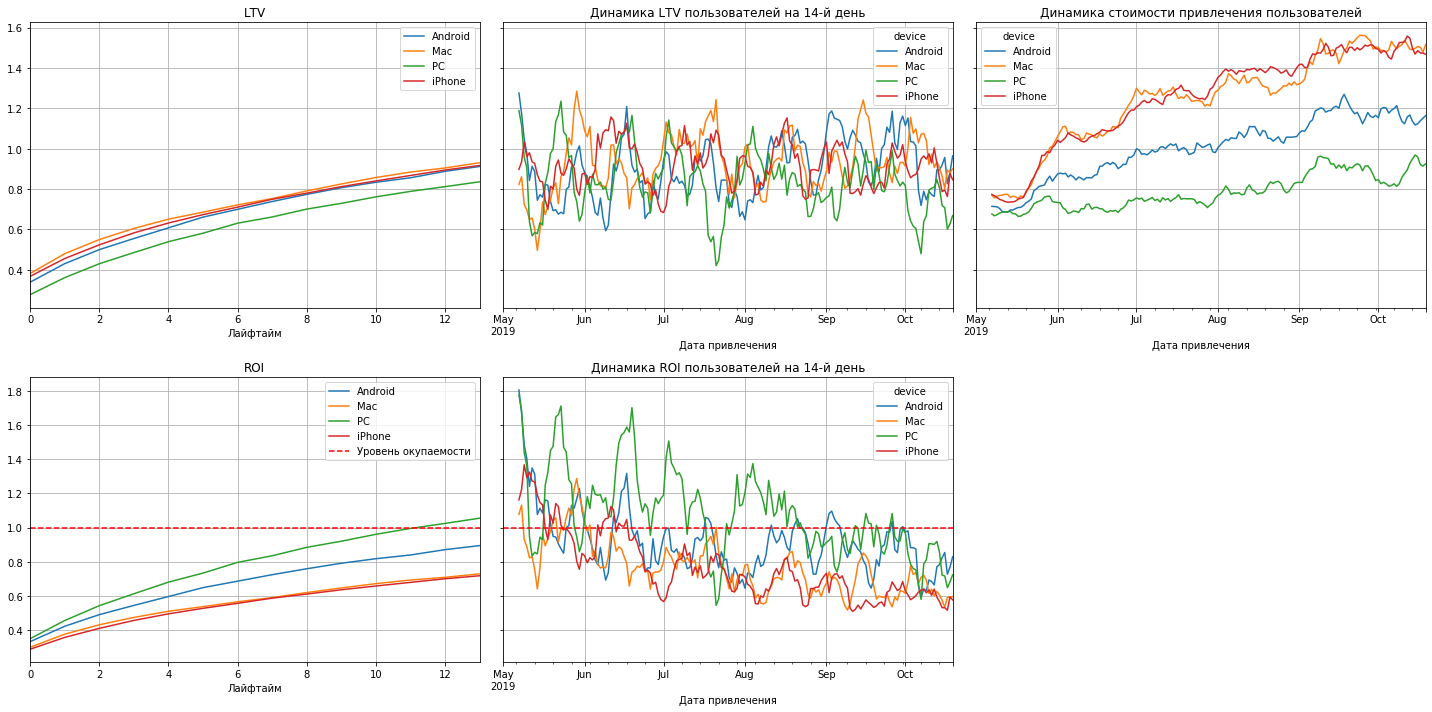

In [21]:
dimensions = ['device']
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles.query('channel != "organic"'), orders, observation_date, horizon_days, dimensions=dimensions
)

# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days)

Разбивка по устройствам показала, что наблюдаемые проблемы не зависят от типа устройства, хотя трафик по устройствам демонстрирует различную эффективность. Пользователи PC окупаются за две недели в отличие от пользователей Android, iPhone и Mac, а затраты на привлечение пользователей Mac и iPhone растут более стремительно, чем у Android и PC.

### Окупаемость рекламы с разбивкой по странам

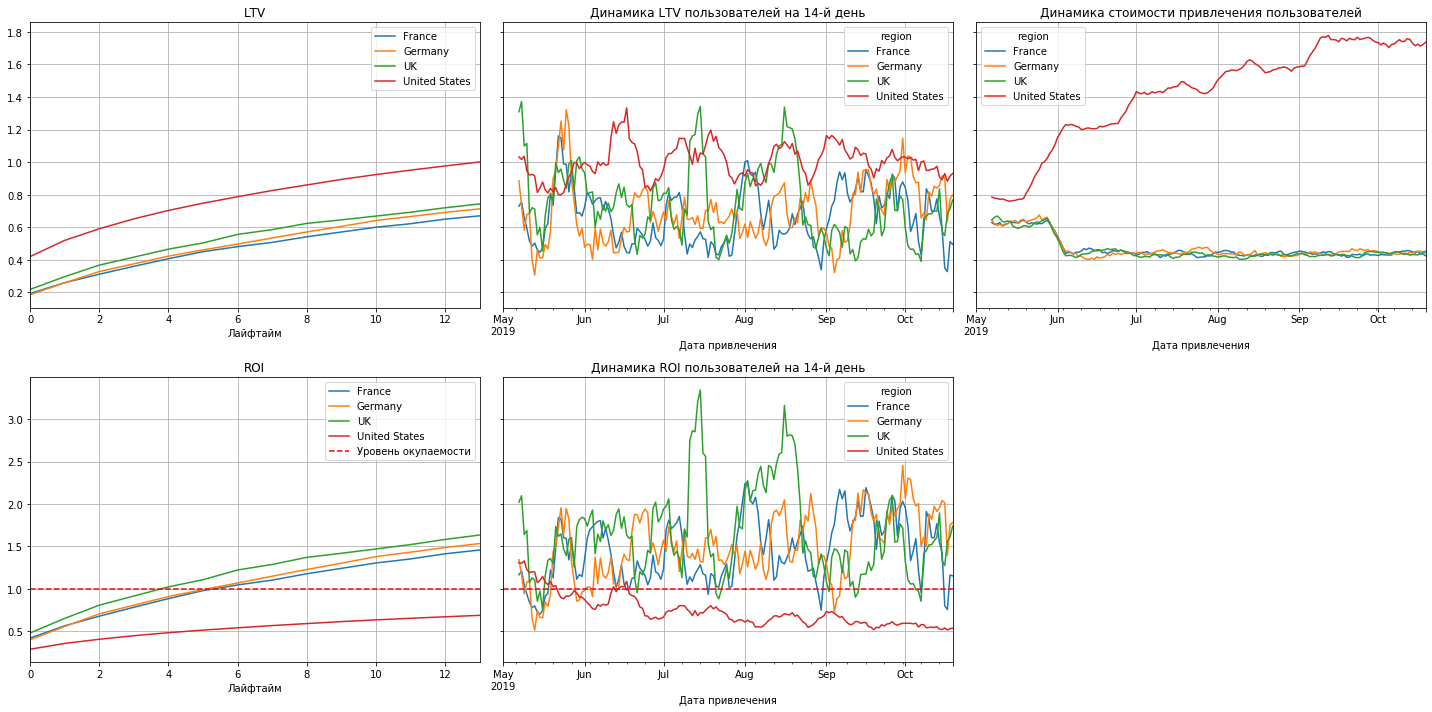

In [22]:
dimensions = ['region']
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles.query('channel != "organic"'), orders, observation_date, horizon_days, dimensions=dimensions
)

# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days)

При разбиении по странам для США наблюдается поведение, отличное от остальных четырёх стран:
1. Это единственная из стран, по которой ROI на вторую неделю меньше уровня окупаемости.
2. По США наблюдается отрицательная динамика возврата инвестиций.
3. Если динамика стоимости привлечения пользователей в других странах в июне снизилась, то в США, начиная с середины мая динамика стоимости привлечения пользователей постоянно возрастает.

### Окупаемость рекламы с разбивкой по рекламным каналам

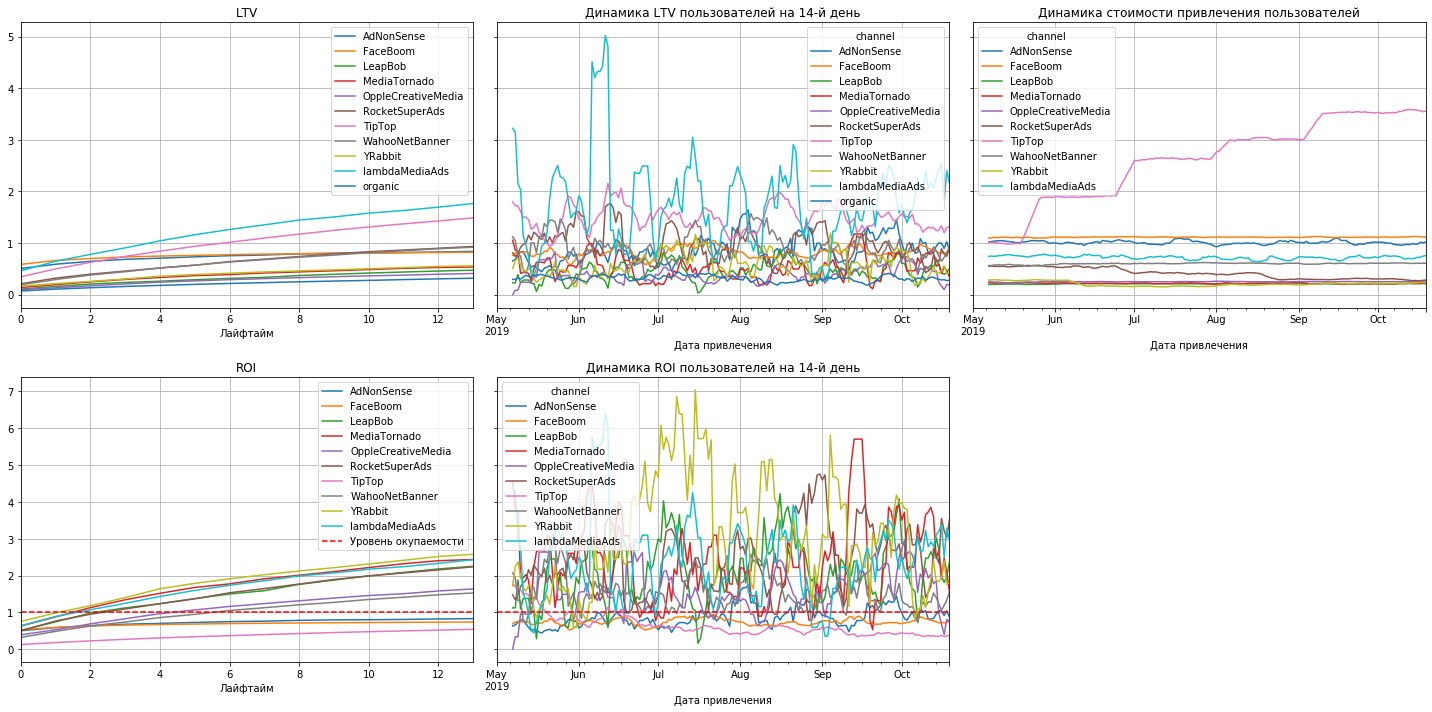

In [23]:
dimensions = ['channel']
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days)


При разбивке по рекламным каналам выявилась явная проблема: начиная с середины мая 2019 наблюдется ступенчатый рост затрат на привлечение одного пользователя по каналу TipTop. Скорее всего, большое число пользователей по данному каналу привлекалось из США.
Так же заметно, что не окупаются пользователи, привлеченные по каналам FaceBoom, AdNonSense.

In [24]:
profiles.query('channel == "TipTop"').groupby('region').agg({'user_id':'count'})

,user_id
region,
United States,19561


Действительно, пользователи по каналу TipTop приходили исключительно из США, а для нас это значительная часть пользователей. Скорее всего, проблемы с iPhone и Mac связаны также с данным каналом.

In [25]:
profiles.query('channel != "organic"').groupby(['region', 'device']).agg({'user_id':'count'})

user_id
region        device          
France        Android     3313
              Mac         1163
              PC          4384
              iPhone      2198
Germany       Android     2849
              Mac         1020
              PC          3797
              iPhone      1862
UK            Android     3243
              Mac         1086
              PC          4551
              iPhone      2274
United States Android    12436
              Mac        15424
              PC          6421
              iPhone     27548

В США большая часть часть клиентов используют Mac или iPhone.

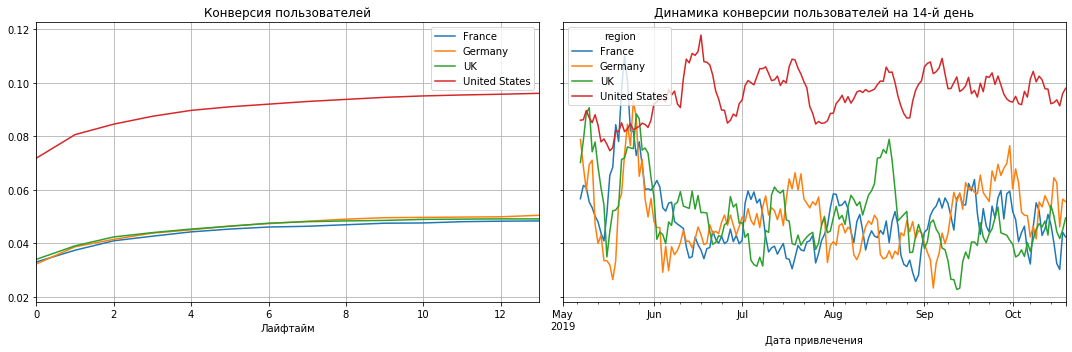

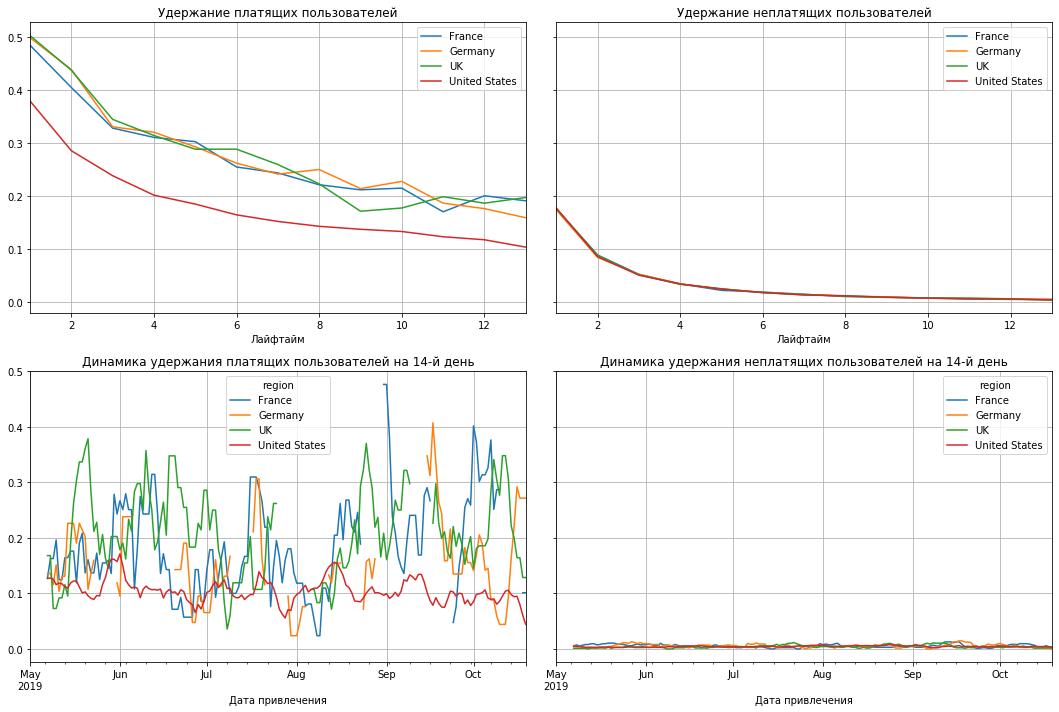

In [26]:
dimensions = ['region']
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles.query('channel != "organic"'), orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days)

Конверсия пользователей, привелекамых из США заметно выше конверсии пользователей из других стран, однако удержаение платящих пользователей заметно хуже. Пользователи из США чаще покупают приложение, но быстро перестают его использовать.

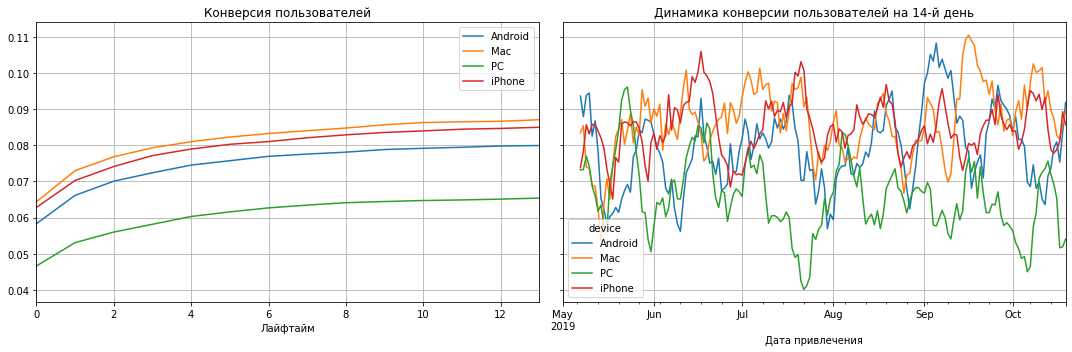

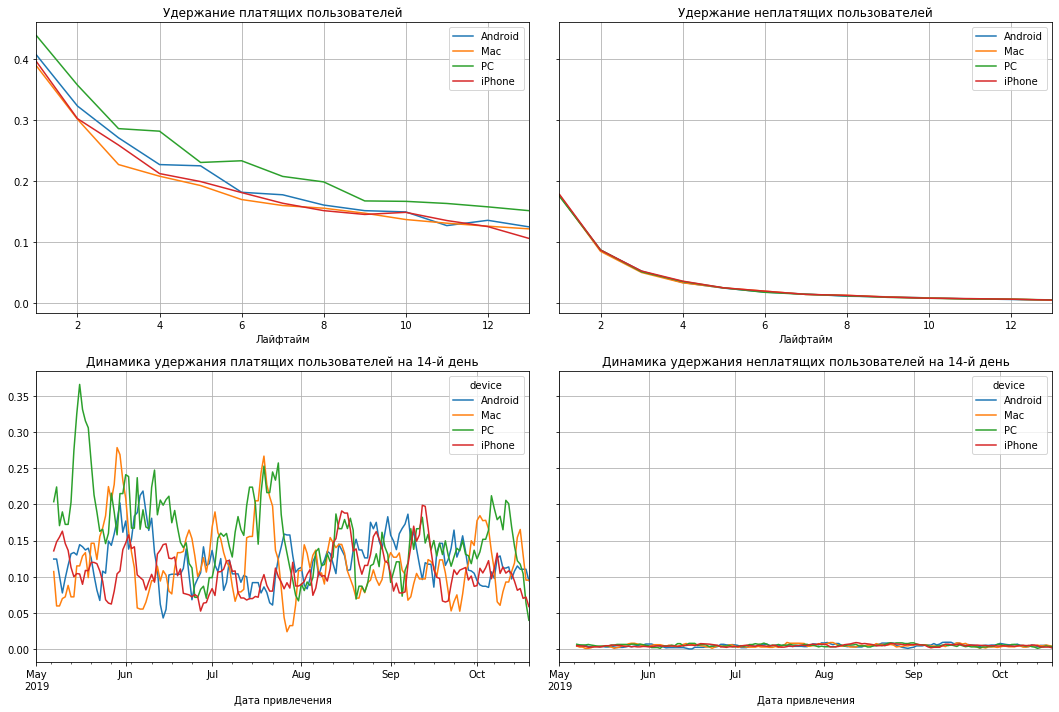

In [27]:
dimensions = ['device']
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles.query('channel != "organic"'), orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days)

Наилучшая конверсия среди пользователей Mac, хуже всего среди пользователей PC, однако заплатившие пользователи PC лучше удерживаются. Пользователи Android и iPhone примерно похожи по поведению.

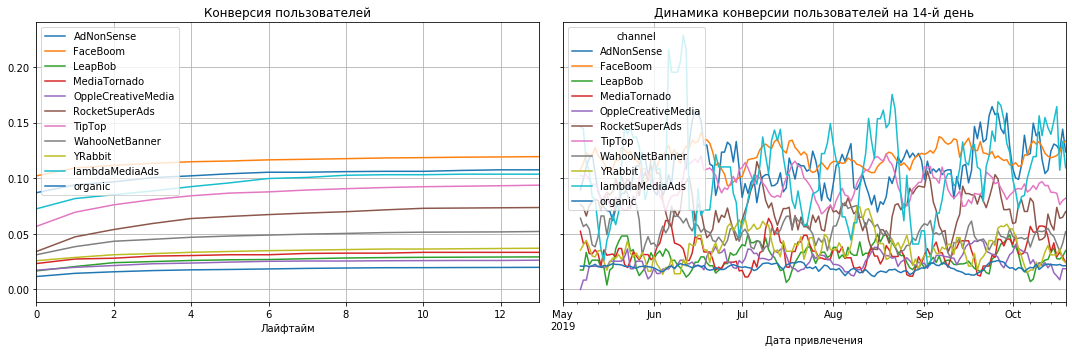

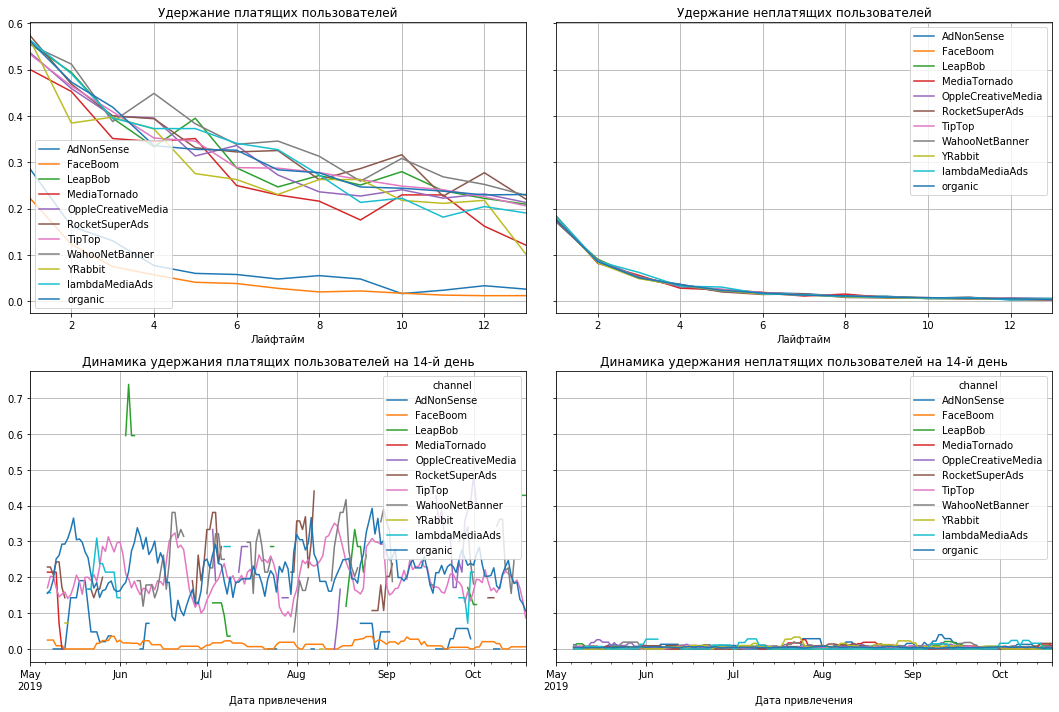

In [28]:
dimensions = ['channel']
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days)

В данной разбивке по каналам наиболее выделяются низкой величиной удержания пользователей каналы AdNonSense и FaceBoom, хотя они же демонстрируют наилучшую конверсию.

# Шаг 6. Выводы

1. Основные причины неэффективности привлечения пользователей:
 1. Многократно возросшие затраты на привлечение пользователей по каналу TipTop с 1 до 3.5 у.е. на пользователя. Несмотря на хорошие показатели по конверсии и удержанию пользователей ROI не достигает границы окупаемости. При этом TipTop привлекает множество пользователей из США, которые составляют большую часть нашей целевой аудитории.
 2. Вторые средним затратам на привлечения одноко пользователя каналы FaceBoom и AdNonSense также не достигают границы окупаемости. Пользователи, которые приходят через эти каналы, крайне плохо удерживаются.
2. Проблема низкой эффективности в неправильно выбранных каналах. Необходимо пересмотреть распределение рекламного бюджета в сторону более эффективных каналов, например, MediaTornado, YRabbit или lambdaMediaAds